# <span style="color:red">Solutions to Homework 5<span>

## Financial Analytics

### UChicago ADSP

#### Spring 2024
* Mark Hendricks
* hendricks@uchicago.edu

Use the data in `data/options_chains.xlsx` regarding `TSLA` as quoted at the end of `July 19, 2023`.

## 1 The Option Chain



### 1.1
Using
* expiration = `Aug 18, 2023`

Plot the market quoted prices of the puts and calls throughout the chain. Plot them against the strike price.

### 1.2
Make the same plot, but instead of market prices of puts and calls, plot the implied volatility of each against the strike price.

What do you notice about this graph? (We will be discussing implied volatility more tomorrow. For now, just focus on the main feature of the graph.)

### 1.3

Suppose that we want to buy `100` units of
* Dec 16 puts at strike of `$280`.
* Dec 16 calls at strike of `$300`.

What is the net cost to set up this position today?

Make a plot of the total net profit at expiration, as a function of the future stock price. Include the cost of setting up the position in the net profit.

***

## 2 Put-Call Parity

For the analysis, focus on the options with
* expiration = Aug 18, 2023
* strike = `$280`

For the interest rate, use SOFR.
* The 3-month Tbill rate is provided if you want to additionally try that to see the difference.

### 2.1

If this were a European option, what would put-call parity suggest the price of the call should be? 
* Note that TSLA does not pay dividends.

### 2.2
Compare this to the actual price of the call.

Suppose that we trust the put-call parity relationship more than the market quote of the call. What trade does this suggest? Be specific.

### 2.3
Now consider that this is an American option, so put-call parity gives an interval of prices rather than a specific price. 

Report this range. Is the market quote inside the interval?

### 2.4

Redo the problem above, but this time for the TSLA calls with
* maturity = `Dec 15, 2023`
* strike = `$300`

***

## 3 Black-Scholes

Consider the put and call options on TSLA
* Strike = `$280`
* Expiration = `August 18, 2023`.

Though these are American options, ignore that and treat them as European.

### 3.1 
Use Black-Scholes to calculate today's value of the put and call.
* Assume annualized volatility of `55\%`.

Graph the value of the call against the price of the stock, holding the time-to-maturity constant at today.

### 3.2
Instead of assuming a volatility and solving for the call value, do the opposite. Assume the call value is the market's quoted price. Solve for the implied volatility that makes this true.

Report the calculated implied volatility.

#### Hint
For solving for the implied volatility, you may want to use
`from scipy.optimize import fsolve`

### 3.3
Re-do the previous questions for the put options on TSLA
* Strike = `$300`
* Expiration = `December 15, 2023`.

***

# <span style="color:red">Solutions</span>

In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)
import sys
sys.path.insert(0, '../cmds')
from options import *

## <span style="color:red">Solution 1</span>

In [2]:
LOADFILE = '../data/options_chains.xlsx'
    
quotes = pd.read_excel(LOADFILE).set_index('date')

QDATE = quotes.index[0]
TICK = quotes.columns[-1]

EXPRY = [expry.strftime('%Y-%m-%d') for expry in quotes.index[1:]]

In [3]:
calls = dict()
puts = dict()

for expry in EXPRY:
    calls[expry] = pd.read_excel(LOADFILE,sheet_name=f'CALLS {expry}').set_index('strike')
    puts[expry] = pd.read_excel(LOADFILE,sheet_name=f'PUTS {expry}').set_index('strike')

### 1.1

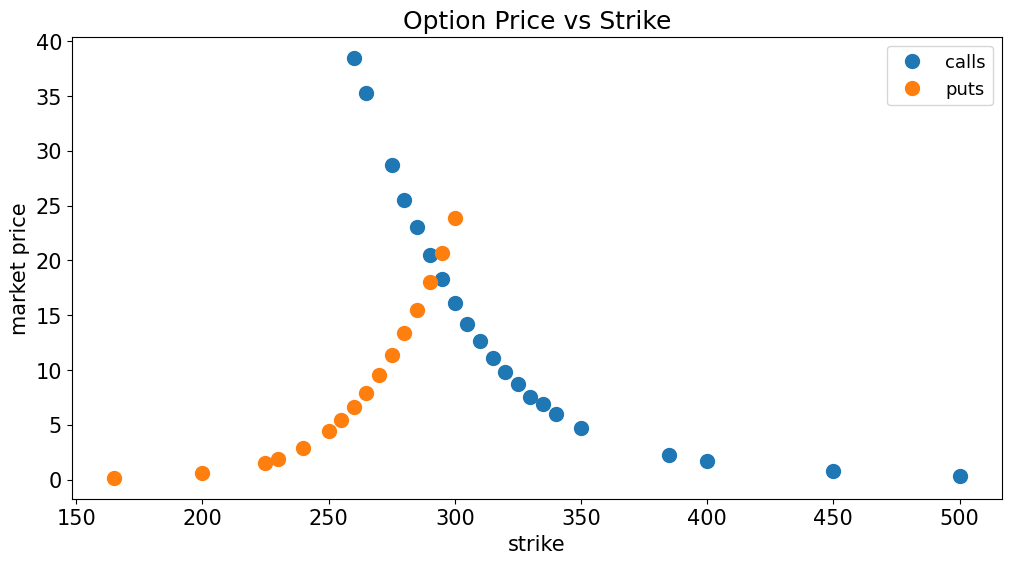

In [4]:
pd.concat([calls[EXPRY[0]]['lastPrice'],puts[EXPRY[0]]['lastPrice']],axis=1).plot(linestyle='',marker='o',markersize=10,ylabel='market price', title='Option Price vs Strike')
plt.legend(['calls','puts']);

### 1.2

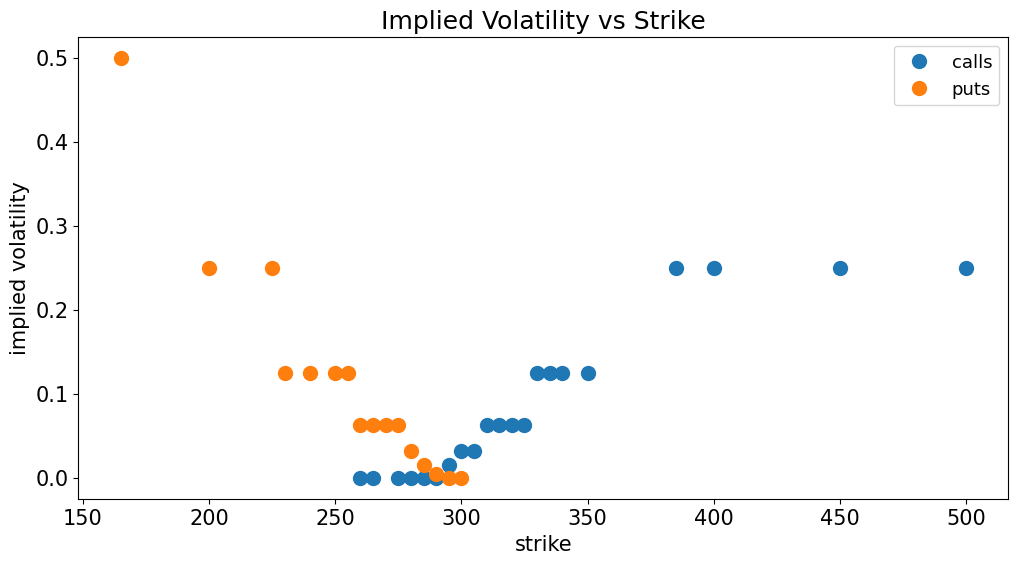

In [5]:
pd.concat([calls[EXPRY[0]]['impliedVolatility'],puts[EXPRY[0]]['impliedVolatility']],axis=1).plot(linestyle='',marker='o',markersize=10,ylabel='implied volatility', title='Implied Volatility vs Strike')
plt.legend(['calls','puts']);

### 1.3

In [6]:
Kput = 280
Kcall = 300
stockgrid = np.arange(200,400)
N = 100

premium = calls[EXPRY[1]].loc[Kcall,'lastPrice'] - puts[EXPRY[1]].loc[Kput,'lastPrice']

holdings = pd.DataFrame(index=stockgrid, columns=['net profit'], dtype=float)
holdings['stock'] = stockgrid
holdings['cost'] = premium
holdings['put payoff'] = (Kput - stockgrid > 0) * ((Kput-stockgrid))
holdings['call payoff'] = (stockgrid-Kcall > 0) * (-(stockgrid - Kcall))
holdings['net profit'] = holdings.sum(axis=1) *N 

Net cost (receipt) for setting up options position is $815.00.


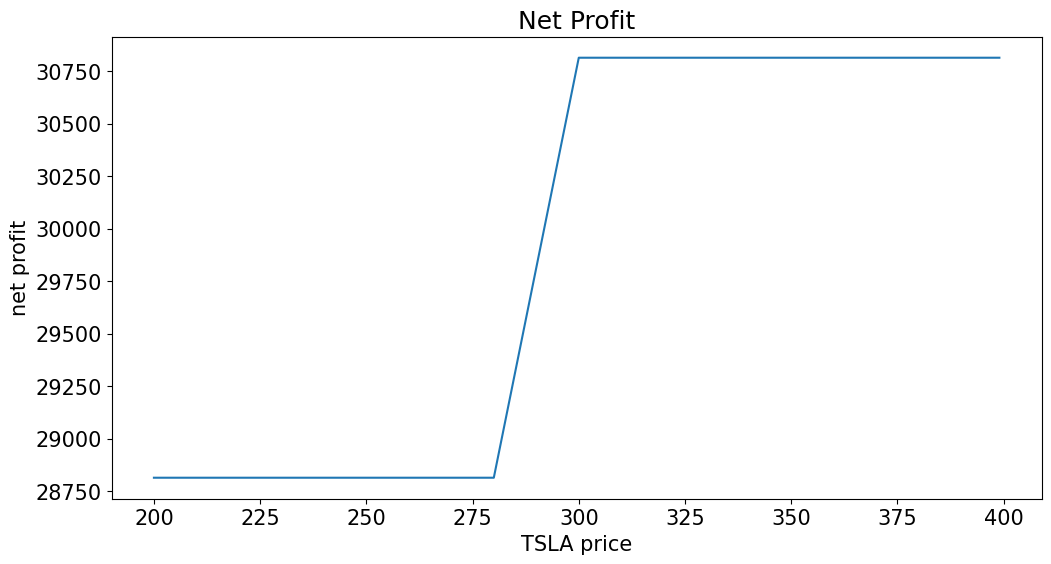

In [7]:
print(f'Net cost (receipt) for setting up options position is ${N*premium:.2f}.')
holdings['net profit'].plot(title='Net Profit',ylabel='net profit',xlabel=f'{TICK} price');

## <span style="color:red">Solution 2</span>

In [8]:
STRIKES = [280,300]

USE_SOFR = True

if USE_SOFR:
    rf = quotes.loc[QDATE,'SOFR']
else:
    rf = quotes.loc[QDATE,'TBill (3mo)']
    
S = quotes.loc[QDATE,TICK]

In [9]:
parity = dict()

for i, expry in enumerate(EXPRY):
    K = STRIKES[i]
    parity[expry] = pd.DataFrame(index=[K],columns=['lower','market','upper'],dtype=float)

    c = calls[expry].loc[K,'lastPrice']
    p = puts[expry].loc[K,'lastPrice']

    tau = to_maturity(expiration=expry, current_date=QDATE)
    disc = np.exp(-rf * tau)

    parity[expry].loc[K,['lower','upper']] = [S-K,S-disc * K]
    parity[expry].loc[K,'market'] = c-p

### Call - Put Spread

In [10]:
pd.concat(parity,axis=1).sort_index().style.format('{:.2f}')

## <span style="color:red">Solution 3</span>

In [11]:
IVOL = .55

In [12]:
pricing_C = pd.DataFrame(columns=['Black-Scholes','Market'],index=EXPRY,dtype=float)
pricing_P = pd.DataFrame(columns=['Black-Scholes','Market'],index=EXPRY,dtype=float)

for i,expry in enumerate(EXPRY):
    K = STRIKES[i]
    tau = to_maturity(expiration=expry, current_date=QDATE)
    
    pricing_C.loc[expry,'Black-Scholes'] = bs_price(under=S,strike=K,T=tau,rf=rf,vol=IVOL)
    pricing_C.loc[expry, 'Market'] = calls[expry].loc[K,'lastPrice']
    
    pricing_P.loc[expry,'Black-Scholes'] = bs_price(under=S,strike=K,T=tau,rf=rf,vol=IVOL,option='put')
    pricing_P.loc[expry, 'Market'] = puts[expry].loc[K,'lastPrice']
    
pricing = pd.concat([pricing_C,pricing_P],axis=1,keys=['Call','Put'])

### (a)

In [13]:
pricing.style.format('{:.2f}')

### (b)

In [14]:
pxgrid = np.arange(S/2,S*1.5)

BSvals = dict()
for i,expry in enumerate(EXPRY):
    BSvals[expry] = pd.DataFrame(index=pxgrid,columns=['Call','Put'],dtype=float)

    K = STRIKES[i]
    tau = to_maturity(expiration=expry, current_date=QDATE)
    
    for px in pxgrid:
        BSvals[expry].loc[px,'Call'] = bs_price(under=px,strike=K,T=tau,rf=rf,vol=IVOL)
        BSvals[expry].loc[px,'Put'] = bs_price(under=px,strike=K,T=tau,rf=rf,vol=IVOL,option='put')

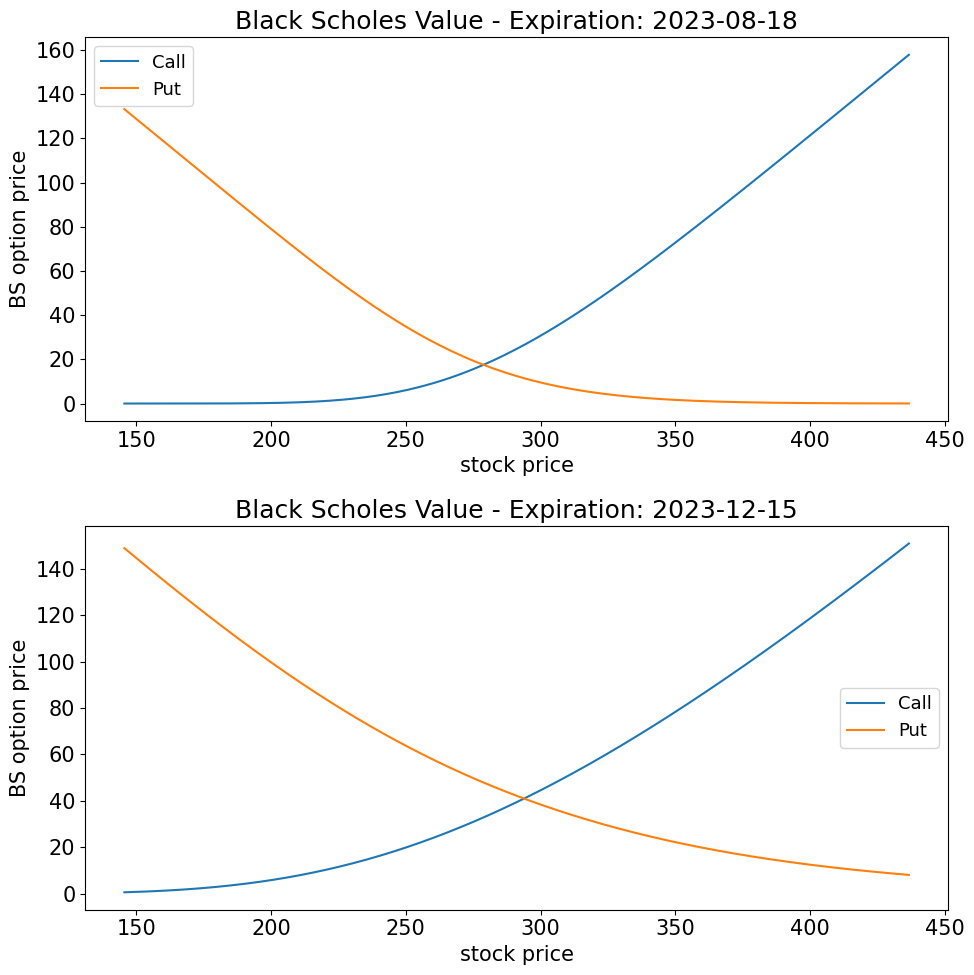

In [15]:
fig, ax = plt.subplots(2,1,figsize=(10,10))
for i, expry in enumerate(EXPRY):
    BSvals[expry].plot(ax=ax[i], xlabel='stock price',ylabel='BS option price',title=f'Black Scholes Value - Expiration: {expry}');
    
plt.tight_layout()
plt.show()

### 3.2

The implied volatility calculations are below.

Note that these are **American** options, yet we are calculating implied volatility with the Black-Scholes formula. Thus, the calculated volatilities will be biased upwards compared to the quoted American implied vols.

In [16]:
px_optC = calls[expry].loc[K,'lastPrice']
px_optP = puts[expry].loc[K,'lastPrice']

ivolBS = pd.DataFrame(index=EXPRY, columns=['call','put'],dtype=float)
ivolQuote = pd.DataFrame(index=EXPRY, columns=['call','put'],dtype=float)

IVOL0 = .55

for i, expry in enumerate(EXPRY):
    K = STRIKES[i]
    tau = to_maturity(expiration=expry,current_date=QDATE)

    ivolBS.loc[expry,'call'] = bs_impvol(under=S,strike=K,T=tau,rf=rf,option='call',opt_price=px_optC,volGuess=IVOL0)
    ivolBS.loc[expry,'put'] = bs_impvol(under=S,strike=K,T=tau,rf=rf,option='call',opt_price=px_optP,volGuess=IVOL0)
    
    ivolQuote.loc[expry,'call'] = calls[expry].loc[K,'impliedVolatility']
    ivolQuote.loc[expry,'put'] = puts[expry].loc[K,'impliedVolatility']
    
ivol = pd.concat([ivolBS,ivolQuote],axis=1,keys=['calculated','quoted'])
ivol.style.format('{:.2%}')

### 3.3

See above.